# Load Dataset (Cora)

In [1]:
%matplotlib inline

import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from graphattack.data import GraphAttackDataset
from graphattack.training import Trainer
from graphattack.training.callbacks import ModelCheckpoint
from graphattack.models import GCN
from graphattack.utils import split_nodes
from graphattack import set_seed
from graphattack.utils import flip_graph

from guard import GUARD, RandomGUARD, DegreeGUARD

dataset = 'cora'

data = GraphAttackDataset(dataset, verbose=True, standardize=True if dataset !='reddit' else False)

g = data[0]
y = g.ndata['label']
splits = split_nodes(y, random_state=15)
    
num_feats = g.ndata['feat'].size(1)
num_classes = data.num_classes
y_train = y[splits.train_nodes]
y_val = y[splits.val_nodes]
y_test = y[splits.test_nodes]

seed = 2022
set_seed(seed)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
g = g.to(device)

Using backend: pytorch


  NumNodes: 2485
  NumEdges: 10138
  NumFeats: 1433
  NumbClasses: 7
Done loading data from cached files.


# Setup GUARD

In [2]:
defense = "GUARD" # RandomGUARD, DegreeGUARD

if defense == "GUARD":
    surrogate = GCN(num_feats, num_classes, bias=False, acts=None)
    surrogate_trainer = Trainer(surrogate, device=device)
    cb = ModelCheckpoint('guard.pth', monitor='val_accuracy')
    surrogate_trainer.fit(g, y_train, splits.train_nodes, val_y=y_val, val_index=splits.val_nodes, callbacks=[cb], verbose=0)        
    guard = GUARD(g.ndata['feat'], g.in_degrees(),  device=device)
    guard.setup_surrogate(surrogate, y_train)
elif defense == "RandomGUARD":
    guard = RandomGUARD(g.num_nodes(), device=device)
elif defense == "DegreeGUARD":
    guard = DegreeGUARD(g.in_degrees(), device=device)
else:
    raise ValueError(f"Unknown defense {defense}")

# Setup Victim Model (GCN)

In [3]:
def get_trainer():
    victim = GCN(num_feats, num_classes)
    trainer = Trainer(victim, device=device)

    cb = ModelCheckpoint('victim.pth', monitor='val_accuracy')
    trainer.fit(g, y_train, splits.train_nodes, val_y=y_val, val_index=splits.val_nodes, callbacks=[cb], verbose=1)
    acc = trainer.evaluate(g, y_test, splits.test_nodes, verbose=0).accuracy
    print(f"Accuracy on test set: {acc:.2%}")
    
    return trainer

runs = 5
trainers = []

for _ in range(runs):
    trainers.append(get_trainer())

Training...
100/100 [==============================] - Total: 1.26s - 12ms/step- loss: 0.053 - accuracy: 0.996 - val_loss: 0.631 - val_accuracy: 0.827
Accuracy on test set: 84.26%
Training...
100/100 [==============================] - Total: 1.25s - 12ms/step- loss: 0.0599 - accuracy: 0.996 - val_loss: 0.6 - val_accuracy: 0.811
Accuracy on test set: 84.10%
Training...
100/100 [==============================] - Total: 1.25s - 12ms/step- loss: 0.055 - accuracy: 1 - val_loss: 0.62 - val_accuracy: 0.823
Accuracy on test set: 84.00%
Training...
100/100 [==============================] - Total: 1.23s - 12ms/step- loss: 0.057 - accuracy: 0.996 - val_loss: 0.617 - val_accuracy: 0.811
Accuracy on test set: 83.95%
Training...
100/100 [==============================] - Total: 1.18s - 11ms/step- loss: 0.0488 - accuracy: 0.996 - val_loss: 0.603 - val_accuracy: 0.827
Accuracy on test set: 84.21%


# Load Adversarial Edges Generated by Different Attacks

In [4]:
attack = 'SGAttack' # 'FGAttack', 'IGAttack'

dir_name = f"perturbations/{dataset}"
file_name = f"{dir_name}/{attack}.pkl"
perturbation = torch.load(file_name)

In [5]:
target = list(perturbation.keys())[1]
target_label = y[target].item()

# clean graph
g

# perturbed graph
edges = perturbation[target] # [2, M]
attack_g = flip_graph(g, edges)

# defensed graph
defense_g = guard(attack_g, target, k=200)
    
target, target_label

(1830, 6)

# Results on Clean, Perturbed, and Defensed Graphs

In [6]:
results = []
for graph in [g, attack_g, defense_g]:
    res = []
    for trainer in trainers:
        # Important for SGC
        trainer.cache_clear()
        res.append(trainer.predict(graph, target).cpu().numpy())
    results.append(res)
        
results = np.array(results)
results.shape

(3, 5, 7)

# Results on Clean Graph vs. Perturbed Graph

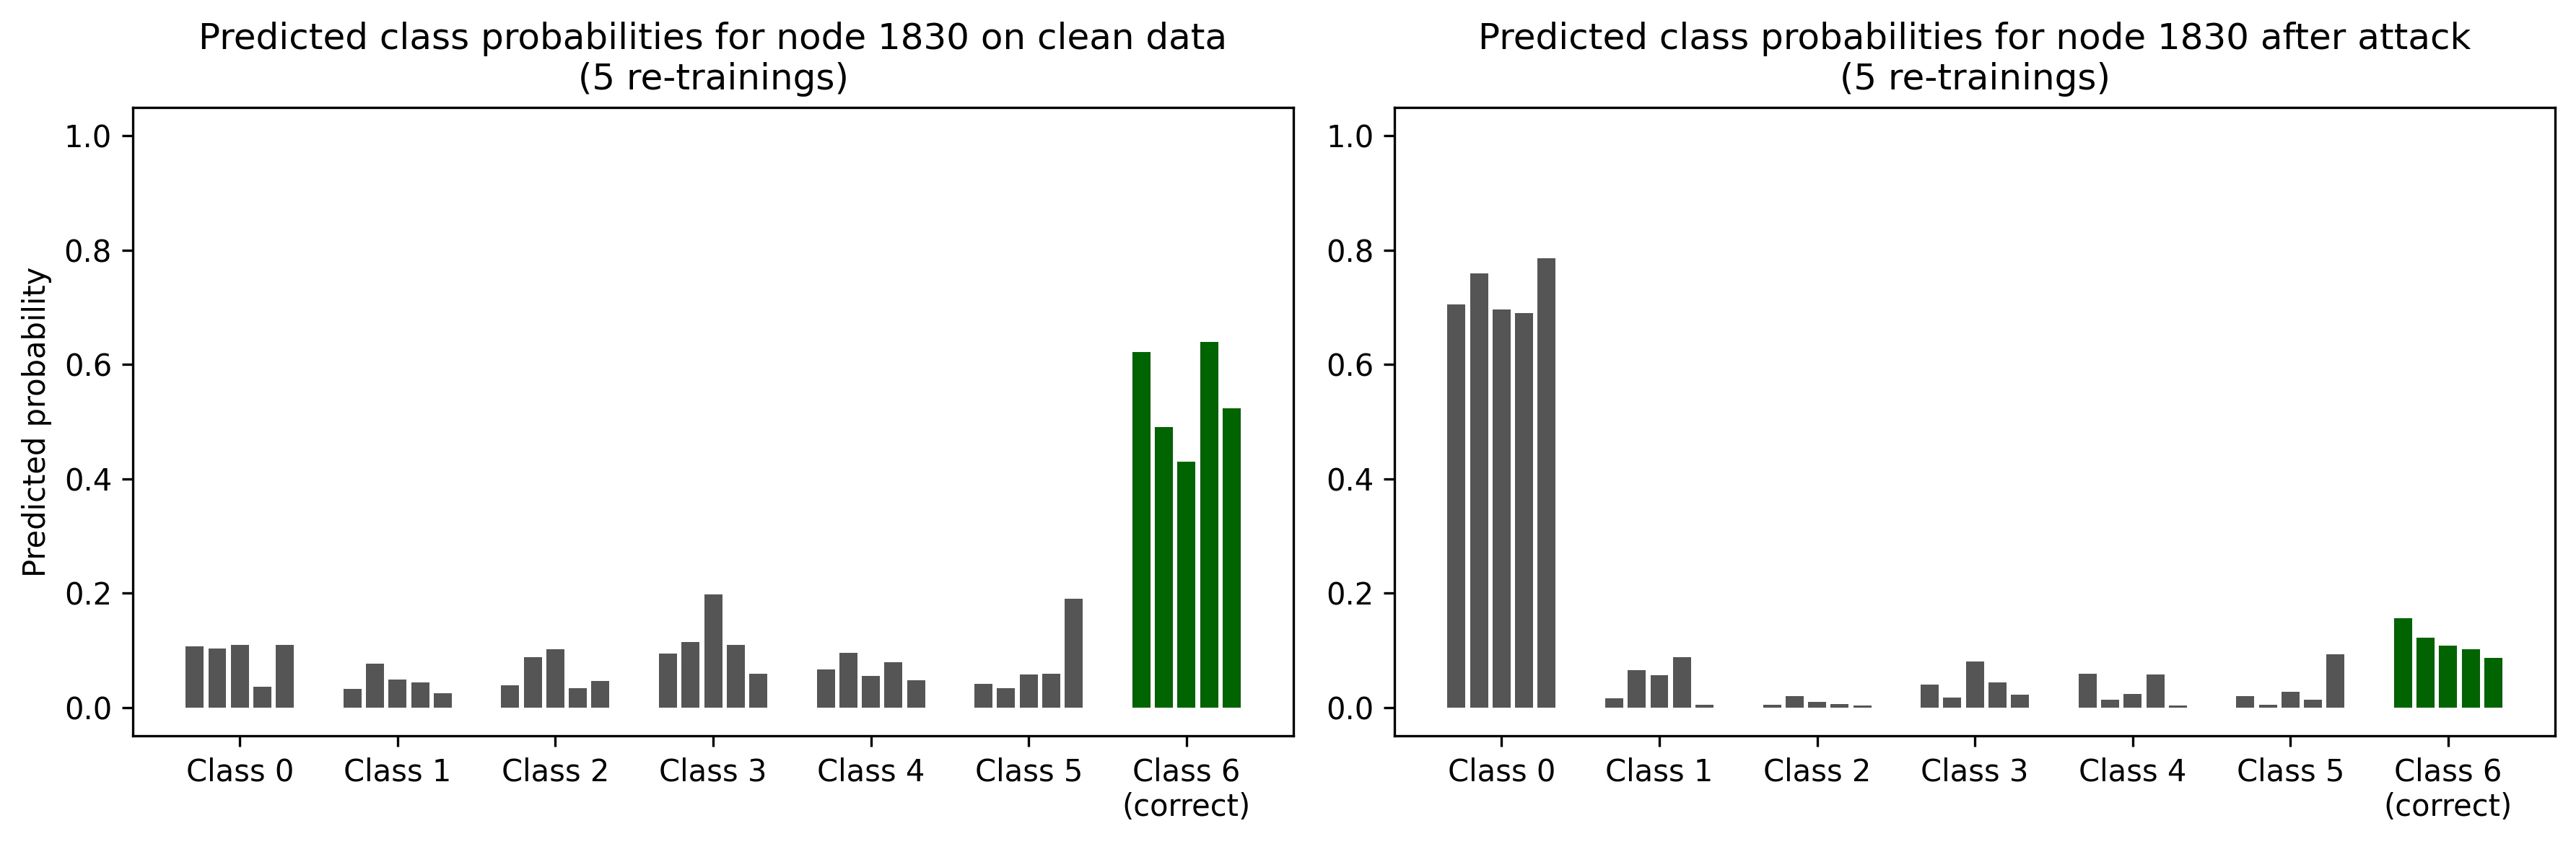

In [7]:
def make_xlabel(ix, correct):
    if ix == correct:
        return "Class {}\n(correct)".format(ix)
    return "Class {}".format(ix)


figure = plt.figure(figsize=(12, 4), dpi=300)
plt.subplot(1, 2, 1)
center_ixs_clean = []
for ix, block in enumerate(results[0].T):
    x_ixs = np.arange(len(block)) + ix*(len(block)+2)
    center_ixs_clean.append(np.mean(x_ixs))
    color = '#555555'
    if ix == y[target]:
        color = 'darkgreen'
    plt.bar(x_ixs, block, color=color)

ax = plt.gca()
plt.ylim((-.05, 1.05))
plt.ylabel("Predicted probability")
ax.set_xticks(center_ixs_clean)
ax.set_xticklabels([make_xlabel(k, y[target]) for k in range(num_classes)])
ax.set_title(f"Predicted class probabilities for node {target} on clean data\n({runs} re-trainings)")

fig = plt.subplot(1, 2, 2)
center_ixs_retrain = []
for ix, block in enumerate(results[1].T):
    x_ixs = np.arange(len(block)) + ix*(len(block)+2)
    center_ixs_retrain.append(np.mean(x_ixs))
    color = '#555555'
    if ix == y[target]:
        color = 'darkgreen'
    plt.bar(x_ixs, block, color=color)


ax = plt.gca()
plt.ylim((-.05, 1.05))
ax.set_xticks(center_ixs_retrain)
ax.set_xticklabels([make_xlabel(k, y[target]) for k in range(num_classes)])
ax.set_title(f"Predicted class probabilities for node {target} after attack\n({runs} re-trainings)")
plt.tight_layout()
plt.show()

# Results on Perturbed Graph vs. Defensed Graph

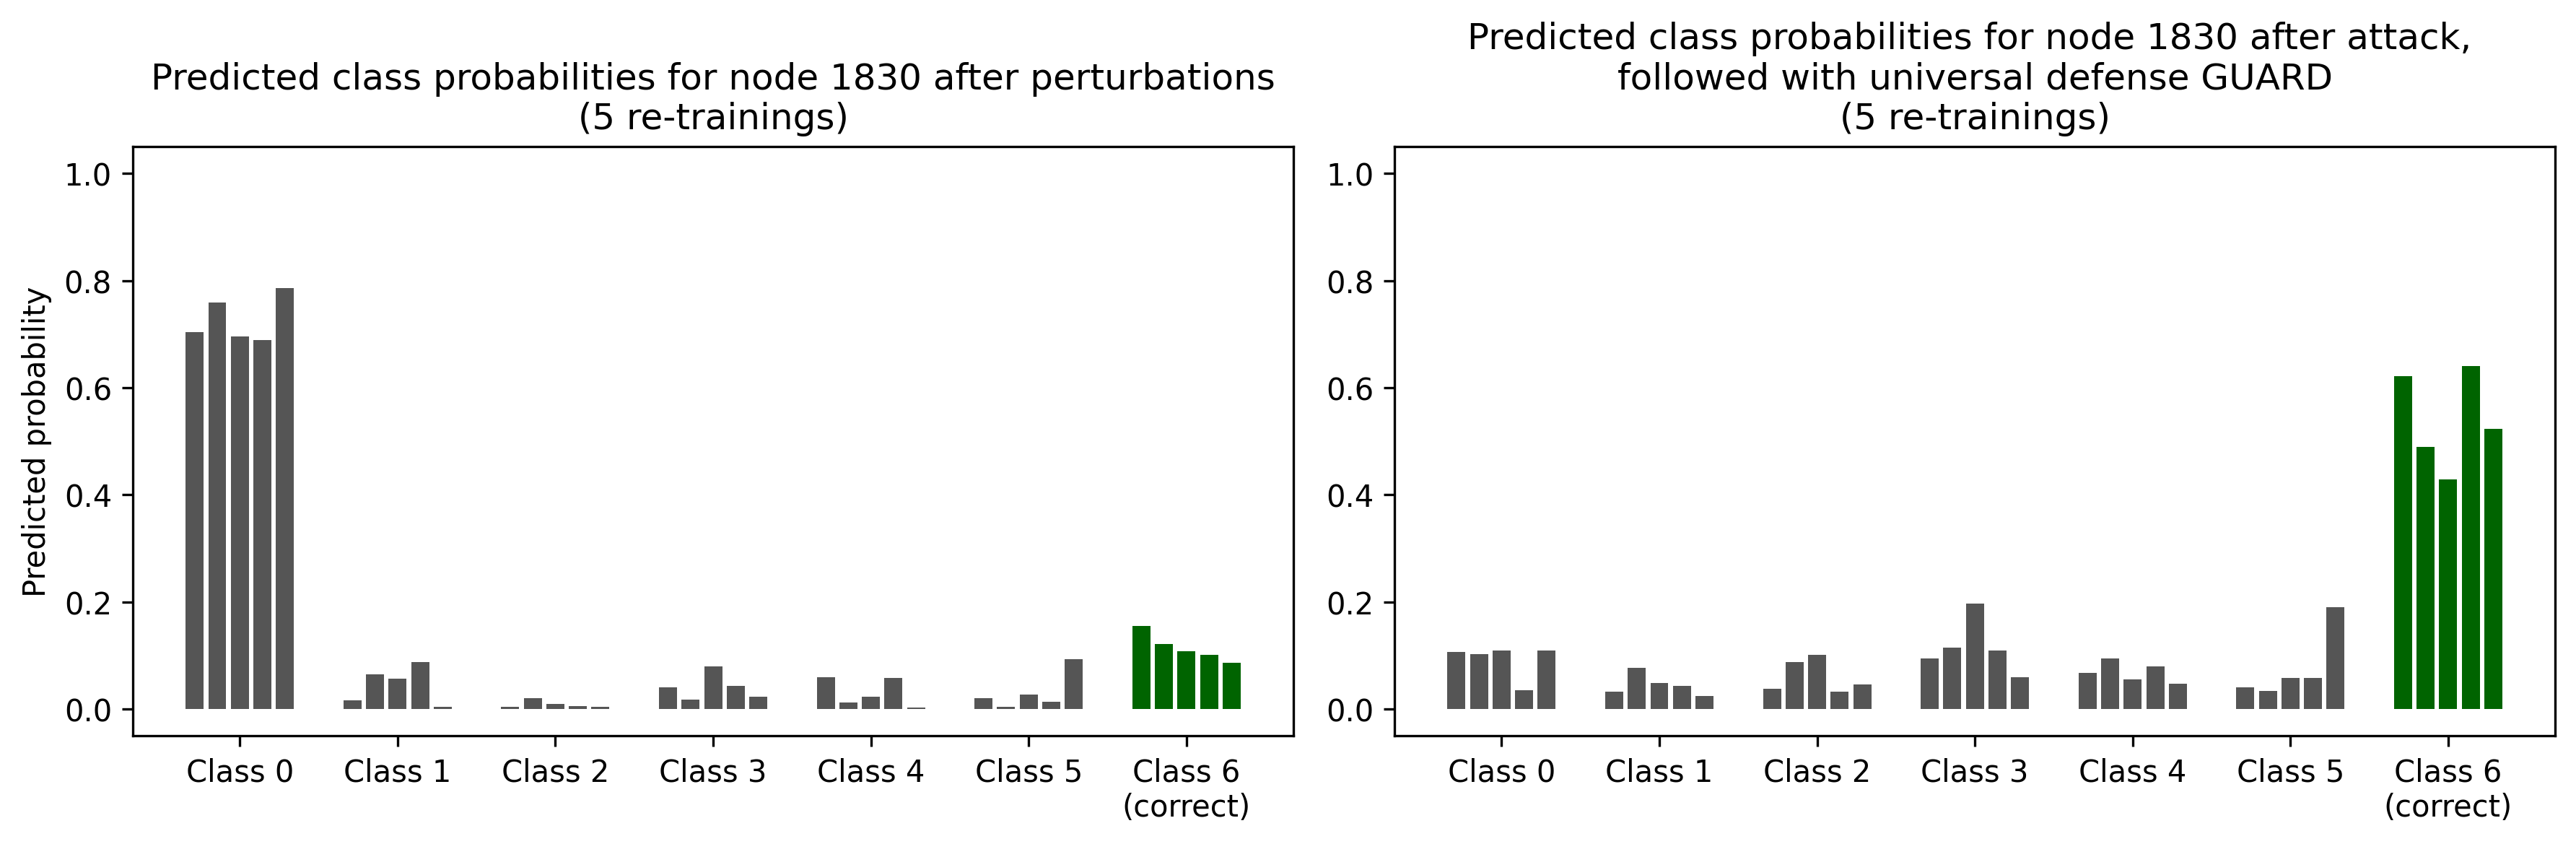

In [8]:
figure = plt.figure(figsize=(12, 4), dpi=300)
plt.subplot(1, 2, 1)
center_ixs_clean = []
for ix, block in enumerate(results[1].T):
    x_ixs = np.arange(len(block)) + ix*(len(block)+2)
    center_ixs_clean.append(np.mean(x_ixs))
    color = '#555555'
    if ix == y[target]:
        color = 'darkgreen'
    plt.bar(x_ixs, block, color=color)

ax = plt.gca()
plt.ylim((-.05, 1.05))
plt.ylabel("Predicted probability")
ax.set_xticks(center_ixs_clean)
ax.set_xticklabels([make_xlabel(k, y[target]) for k in range(num_classes)])
ax.set_title(f"Predicted class probabilities for node {target} after perturbations\n({runs} re-trainings)")

fig = plt.subplot(1, 2, 2)
center_ixs_retrain = []
for ix, block in enumerate(results[2].T):
    x_ixs = np.arange(len(block)) + ix*(len(block)+2)
    center_ixs_retrain.append(np.mean(x_ixs))
    color = '#555555'
    if ix == y[target]:
        color = 'darkgreen'
    plt.bar(x_ixs, block, color=color)


ax = plt.gca()
plt.ylim((-.05, 1.05))
ax.set_xticks(center_ixs_retrain)
ax.set_xticklabels([make_xlabel(k, y[target]) for k in range(num_classes)])
ax.set_title(f"Predicted class probabilities for node {target} after attack, \nfollowed with universal defense GUARD\n({runs} re-trainings)")
plt.tight_layout()
plt.show()